In [ ]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
# other dependencies
!pip install timm ipywidgets seaborn pytorch_lightning

In [ ]:
## nnAudio
!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

In [1]:
# python standard
from glob import glob
import math
import os
import pickle
import random
#from typing import Callable, Dict, Union, Optional, List
# python universe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

import sklearn
from sklearn.metrics import accuracy_score


from tqdm.notebook import tqdm

In [2]:
# local
import sys
sys.path.insert(0, os.path.abspath('../src'))
import config

from evaluate_torch import get_results, evaluate_model_timestamp

In [3]:
# additional pytorch tools
import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F

import torchaudio
import torchvision

import torchaudio.transforms as AT
import torchvision.transforms as VT

import torchmetrics

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler

import timm

In [4]:
from nnAudio import features

In [5]:
batch_size = 32
pin_memory = True
num_workers = 0

config.NFFT = 2048
config.win_size = 60
config.n_hop = config.NFFT // 8
config.step_size = config.win_size // 1
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

In [6]:
df = pd.read_csv('/my_data/UCB/W210/ComParE2022/data/metadata/humbugdb_zenodo_0_0_2.csv')

# To be kept: please do not edit the dev set: these paths select dev set a, dev set b as described in the paper
idx_dev_a = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'field')
idx_dev_b = np.logical_and(df['country'] == 'UK', df['location_type'] == 'culture')
idx_train = np.logical_not(np.logical_or(idx_dev_a, idx_dev_b))
df_dev_a = df[idx_dev_a]
df_dev_b = df[idx_dev_b]


df_train = df[idx_train].reset_index(drop=True)

# Modify by addition or sub-sampling of df_train here
# df_train ... 

# Assertion to check that train does NOT appear in dev:
assert len(np.where(pd.concat([df_train,df_dev_a,
                               df_dev_b]).duplicated())[0]) == 0, 'Train dataframe contains overlap with dev A, dev B'

In [7]:
# come on feel the noise

# first get the length of all the MUSAN noises https://www.openslr.org/17/ --> data/noise
files_noise = glob('../../HumBugDB/data/noise/**/*.wav')+glob('../../HumBugDB/data/audioset/*.wav')
df_noise = pd.DataFrame([{'path': f, 'length': torchaudio.sox_effects.apply_effects_file(f, effects=[["rate", f'{config.rate}']])[0].shape[1]/config.rate} for f in tqdm(files_noise)])
# make the noise in the training data match the format
df_noise_train = df_train[(df_train['sound_type']!='mosquito')][['id','length']]
df_noise_train = df_noise_train[df_noise_train['length']>min_length].sample(frac=0.19)
df_noise_train['path'] = df_noise_train['id'].apply(lambda x: os.path.join(config.data_dir_train,f'{x}.wav'))
df_noise = pd.concat([df_noise,df_noise_train[['path','length']]],ignore_index=True)

  0%|          | 0/4012 [00:00<?, ?it/s]

In [8]:
def get_offsets_df(df, min_length, win_size, step_size, short_audio=False):
    audio_offsets = []
    step_frac = config.step_size/config.win_size
    for _, row in tqdm(df.iterrows(), total=len(df)):
        if row['length'] > min_length:
            step_size = step_frac * min_length
            audio_offsets.append({
                'index': row.name,
                'id': row['id'],
                'offset': 0,
                'sound_type': row['sound_type'],
                'species': row['species'],
                'length': row['length']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({
                    'index': row.name,
                    'id': row['id'],
                    'offset': int(min_length+(i*step_size)*config.rate),
                    'sound_type': row['sound_type'],
                    'species': row['species'],
                    'length': row['length']})
        elif short_audio:
            audio_offsets.append({'index':row.name,'id':row['id'], 'offset':0,'sound_type': row['sound_type'], 'length': row['length']})
    return pd.DataFrame(audio_offsets)       

In [9]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, noise_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                 ["rate", f'{resample}'],
                  ['gain', '-n'],
                ["highpass", "500"],
                ])

            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            if waveform.shape[1] < config.rate*self.min_length:
                r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
                f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
            else:    
                f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            #f = f_out.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        #if real_idx % 2 == 0 and self.audio_df.loc[real_idx]['sound_type'] == 'mosquito':
        #if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' and random.randint(0,1)==1:
        if random.randint(0,1)==0:
            sample_length = x.shape[1] / config.rate#sample_length = self.audio_df.loc[real_idx]['length']
            if len(self.noise_df[self.noise_df['length'] >= sample_length]) > 0:
                noise_path = self.noise_df[self.noise_df['length'] >= sample_length].sample(1).iloc[0]['path']
                noise, _ = self._get_sample_(noise_path, resample=config.rate)
                
                noise_length_difference = noise.shape[1]-x.shape[1] 
                
                random_noise_offset = 0 if noise_length_difference==0 else random.randrange(0,noise_length_difference)
                noise = noise[:, random_noise_offset:random_noise_offset+x.shape[1]]

                mos_power = x.norm(p=2)
                noise_power = noise.norm(p=2)

                snr = math.exp(random.randint(2,5) / 10)
                
                scale = snr * noise_power / mos_power
                x = (scale * x + noise) / 2
        
        offset = self.audio_df.loc[real_idx]['offset']
        label = torch.tensor([0.0,1.0]) if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' else torch.tensor([1.0,0.0])
        return x[:, offset:int(offset + config.rate * self.min_length)], label


In [10]:
class MozTestDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                  ["rate", f'{resample}'],
                  ['gain', '-n'],
                ["highpass", "200"],
                ])
            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            if waveform.shape[1] < config.rate*self.min_length:
                left_pad_amt = int((config.rate*min_length-waveform.shape[1])//2)
                left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
                right_pad_amt = int(config.rate*min_length-waveform.shape[1]-left_pad_amt)
                right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
                f = torch.cat([left_pad,waveform,right_pad],dim=1)[0]
                f = ((0.0001**0.5)*torch.randn(1, int(config.rate*min_length))+f)[0]
#                 r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
#                 f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
            else:    
                f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            #return waveform, rate, waveform
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
#             f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
    
        offset = self.audio_df.loc[real_idx]['offset']
        label = torch.tensor([0.0, 1.0]) if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' else torch.tensor([1.0, 0.0])
        return x[:, offset:int(offset + config.rate * self.min_length)], label
    
    

In [11]:
# initialize empty cache
# it would be great if this was something cooler than a dictionary
audio_cache={}

In [12]:
valid_size = 0.2
shuffle = True
random_seed = 142

# needed for cache
num_workers=0
pin_memory=True

num_train = len(df_train)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(range(len(train_idx)))
valid_sampler = SubsetRandomSampler(range(len(valid_idx)))

df_audio_train = get_offsets_df(df_train.loc[train_idx], short_audio=True)
df_audio_val = get_offsets_df(df_train.loc[valid_idx], short_audio=True)

train_dataset = MozTrainDataset(df_audio_train, df_noise, config.data_dir_train, min_length, audio_cache)
val_dataset = MozTrainDataset(df_audio_val, df_noise, config.data_dir_train, min_length, audio_cache)

  0%|          | 0/6557 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

In [13]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
        x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
        x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [14]:
class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, t_config) -> None:
        super().__init__()
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        spec_layer = features.STFT(n_fft=t_config['n_fft'], freq_bins=None, hop_length=t_config['n_fft'] // t_config['n_hop'],
                              window='hann', freq_scale=t_config['freq_scale'], center=True, pad_mode='reflect',
                          fmin=t_config['fmin'], fmax=t_config['fmax'], sr=config.rate, output_format="Magnitude", trainable=True)
#         self.spec_layer = features.MelSpectrogram(n_fft=config.NFFT, n_mels=128, hop_length=config.n_hop,
#                                 window='hann',  center=True, pad_mode='reflect',
#                           sr=config.rate,  trainable_mel=True, trainable_STFT=True)
#         self.out = nn.Linear(self.backbone.num_features, 1)
        sizer = VT.Resize((t_config['image_size'], t_config['image_size']))
        norm_layer = VT.Normalize(mean[1:2], std[1:2])
        pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)

        self.transforms = nn.Sequential(
            spec_layer,
            pcen_layer,
            norm_layer,
            sizer
        )

    def forward(self, x: Tensor) -> Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        return x_out

In [22]:
# Subclass the pretrained model and make it a binary classification

class MozzModel(LightningModule):
    def __init__(self, model_config):
        super().__init__()
        
        # num_classes=0 removes the pretrained head
        self.model = timm.create_model(model_config['model_name'],
                        pretrained=True, num_classes=2, in_chans=1, 
                        drop_path_rate=0.05, global_pool='avgmax',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.model.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'stages.3' not in name and 'layers.3' not in name \
                and 'blocks.26' not in name and 'blocks.26' not in name \
                and 'blocks.24' not in name and 'blocks.25' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.20' not in name and 'blocks.21' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.19' not in name and 'blocks.18' not in name \
                and 'blocks.17' not in name and 'blocks.5.' not in name:
                param.requires_grad = False
        #### end layer freezing
        aug_config = {
            "n_fft": 2048,
            "n_hop": 8,
            "freq_scale": "log",
            "fmin": 300,
            "fmax": 3800,
            "image_size": model_config["image_size"]
        }
        
        self._transforms = DataAugmentation(aug_config)
        
        self.timeMasking = AT.TimeMasking(time_mask_param=30, iid_masks=True)
        self.freqMasking = AT.FrequencyMasking(freq_mask_param=20, iid_masks=True)
        self.softmax = nn.Softmax(dim=1)
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        
        self.batch_size = 32
        self.lr = 0.000165
        
    def forward(self, x):
        
        x = self._transforms(x)
        if self._trainer and self._trainer.training:
            x = self.timeMasking(x)
            x = self.freqMasking(x)

        # then repeat channels
        pred = self.model(x)
        pred = self.softmax(pred)
#        pred = self.out(x)
        
        output = {"prediction": pred,
                  "spectrogram": x}
        return output

    def compute_loss(self, y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)
    
    def show_batch(self, win_size=(10, 10)):
        def _to_vis(data):
            return torchvision.utils.make_grid(data, nrow=8)[0]
        # get a batch from the training set: try with `val_datlaoader` :)
        snds, labels = next(iter(self.train_dataloader()))
        with torch.no_grad():
            imgs_aug = self._transforms(snds)  # apply transforms
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs_aug))
        
#     def on_after_batch_transfer(self, batch, dataloader_idx):
#         x, y = batch
#         if self.trainer.training:
#             x = self._transform(x)  # => we perform GPU/Batched data augmentation
#         return x, y

    def accuracy(self, y_hat, labels):
        #_, predicted = torch.max(logits.data, 1)
        correct = (torch.argmax(y_hat["prediction"], dim=1) == torch.argmax(labels, dim=1)).sum().item()
        accuracy = correct / len(labels)
        return torch.tensor(accuracy)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat["prediction"], y)
        self.train_accuracy.update(torch.argmax(y_hat["prediction"], dim=1), torch.argmax(y, dim=1))
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_accuracy, prog_bar=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat["prediction"], y)
        self.val_accuracy.update(torch.argmax(y_hat["prediction"], dim=1), torch.argmax(y, dim=1))
        accuracy = self.accuracy(y_hat, y)
        return {"val_loss": loss, "val_accuracy": accuracy}
#         self.log("valid_loss", loss, prog_bar=False)
#         self.log("valid_acc", self.val_accuracy, prog_bar=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["val_accuracy"] for x in outputs]).mean()
        self.log("ptl/val_loss", avg_loss)
        self.log("ptl/val_accuracy", avg_acc)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat["prediction"], y)
        self.val_accuracy.update(torch.argmax(y_hat["prediction"], dim=1), torch.argmax(y, dim=1))
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.val_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]

#     def prepare_data(self):
#         CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
#         CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)

    def train_dataloader(self):
        #dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        loader = DataLoader(train_dataset, batch_size=int(self.batch_size),
            num_workers=num_workers, pin_memory=pin_memory)
        return loader

    def val_dataloader(self):
        #dataset = CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)
        loader = DataLoader(val_dataset, batch_size=int(self.batch_size),
            num_workers=num_workers, pin_memory=pin_memory)
        return loader

In [149]:
model_config = {
    "model_name": "convnext_base_384_in22ft1k",
    "image_size": 384,
}
model = MozzModel(model_config)

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0168 seconds


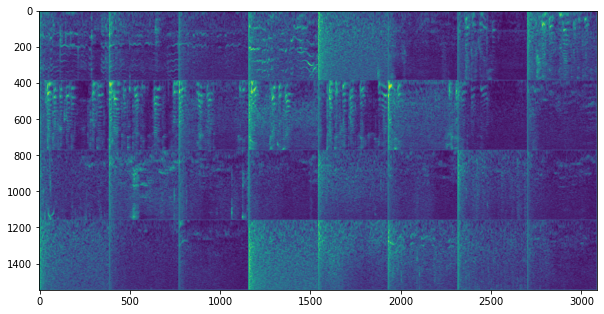

In [146]:
model.show_batch()

In [ ]:
import warnings

warnings.filterwarnings("ignore", ".*To copy construct from a tensor.*")
# Initialize a trainer
trainer = Trainer(
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=10,
    precision=16,
    logger=CSVLogger(save_dir="logs/"),
    default_root_dir="checkpoints/"
)

# Train the model ⚡
trainer.fit(model)


,train_loss,valid_loss,valid_acc
epoch,,,
0,0.225230,NaN,NaN
0,0.231173,NaN,NaN
0,0.214555,NaN,NaN
0,0.062602,NaN,NaN
0,0.068348,NaN,NaN


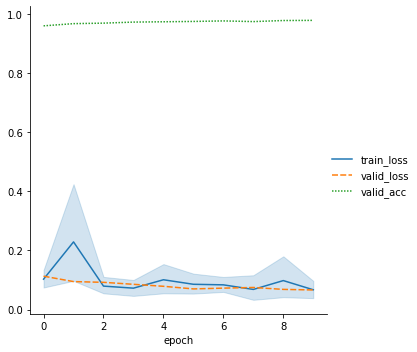

In [22]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [23]:
trainer.save_checkpoint("../models/2022-09-16_2.ckpt")

In [24]:
# eval

In [ ]:
model = MozzModel.load_from_checkpoint("../models/2022-09-16_2.ckpt",
                                        model_name='convnext_base_384_in22ft1k',
                                        image_size=384)

# print(model.learning_rate)
# prints the learning_rate you used in this checkpoint

model.eval()
# y_hat = model(x)

In [26]:
def evaluate_model(model, test_loader, n_samples, n_channels=3):
    with torch.no_grad():
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f'Evaluating on {device}')

        softmax = nn.Softmax(dim=1)
        
        y_preds_all = torch.zeros([n_samples, len(test_loader.dataset), 2])
        model = model.to(device)
        model.eval() # Important to not leak info from batch norm layers and cause other issues
        
        for n in range(n_samples):
            all_y_pred = []
            all_y = []
            all_spec = []
            for x, y in tqdm(test_loader):
                x, y = x.to(device), y.to(device)

                model_out = model(x)

                all_y.append(y.cpu().detach())
                all_y_pred.append(model_out["prediction"].cpu().detach())
                
                all_spec.append(model_out["spectrogram"].cpu().detach())

                del x
                del y
                del model_out

            all_y_pred = torch.cat(all_y_pred)
            all_y = torch.cat(all_y)

            y_preds_all[n,:] = softmax(all_y_pred)
#             y_preds_all[n,:,1] = np.array(sigmoid(all_y_pred).squeeze())
#             y_preds_all[n,:,0] = 1-np.array(sigmoid(all_y_pred).squeeze()) # Check ordering of classes (yes/no)
            test_acc = accuracy_score(torch.argmax(all_y, dim=1).numpy(), torch.argmax(all_y_pred, dim=1).numpy())
            print(test_acc)
    return y_preds_all, all_y, all_spec

In [16]:
audio_df_test_A = get_offsets_df(df_dev_a, short_audio=True)
audio_df_test_B = get_offsets_df(df_dev_b, short_audio=True)

dataset_test_A = MozTestDataset(audio_df_test_A, config.data_dir_dev_a, min_length, audio_cache)

test_loader_A = torch.utils.data.DataLoader(
        dataset_test_A, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

dataset_test_B = MozTestDataset(audio_df_test_B, config.data_dir_dev_b, min_length, audio_cache)

test_loader_B = torch.utils.data.DataLoader(
        dataset_test_B, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

  0%|          | 0/2165 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [22]:
feat_type = 'MIDS'
model_name = 'MIDS_PL_022-09-16_2'

y_preds_all, y_test_A = evaluate_model(model, test_loader_A, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all.numpy(), torch.argmax(y_test_A, dim=1).numpy(), filename = feat_type + '_' + model_name +'_Test_A')

Evaluating on cuda:0


  0%|          | 0/182 [00:00<?, ?it/s]

0.8614219314856257


Evaluating on cuda:0


  0%|          | 0/43 [00:00<?, ?it/s]

0.8389458272327965



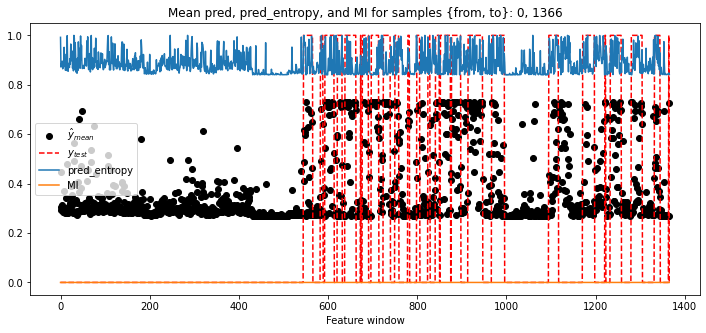

mean ROC AUC: 0.7634194043914453


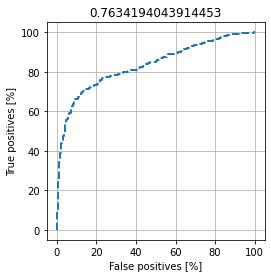

std ROC AUC: 0.0
PR-AUC:  0.5811926423372524


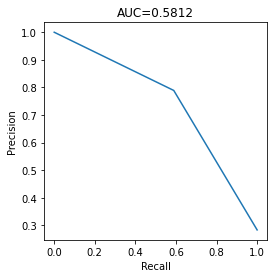

Confusion matrix, as input by user
[[93.7692  6.2308]
 [41.0853 58.9147]]


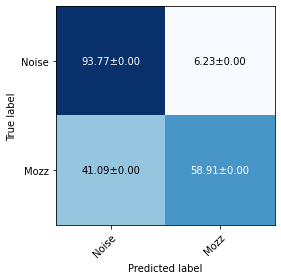

In [28]:
y_preds_all, y_test_B, y_spec = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all.numpy(), torch.argmax(y_test_B, dim=1).numpy(), filename = feat_type + '_' + model_name +'_Test_B')